In [1]:
import jax
import jax.numpy as jnp
from ml_collections import config_flags
import numpy as np
import matplotlib.pyplot as plt
from absl import app, flags

from tensorflow.keras.datasets import mnist

import math, os
from typing import Any, Callable, Mapping, Sequence, Tuple
from jax import Array
from flax import linen as nn
from flax.training import train_state, orbax_utils
import optax
import wandb
from orbax.checkpoint import CheckpointManager, PyTreeCheckpointer
from pathlib import Path
import tqdm
from einops import rearrange

from galaxy_diffusion import training_utils
from galaxy_diffusion.corrupted_mnist import datasets
from galaxy_diffusion.corrupted_mnist import metrics

from galaxy_diffusion.corrupted_mnist import config_base_grass
from galaxy_diffusion.corrupted_mnist import config_base_mnist
import models
imagenet_path = '/mnt/home/aakhmetzhanova/ceph/galaxy-diffusion/corrupted-mnist/dataset/grass_jpeg/' 


2025-05-16 06:41:16.414670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747392076.433976 1372540 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747392076.439993 1372540 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747392076.456698 1372540 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747392076.456716 1372540 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747392076.456718 1372540 computation_placer.cc:177] computation placer alr

In [2]:
class cVAE(nn.Module):
    r"""Creates an cVAE model. 
    Assumes that the input is a flattened image and the dimensionality of the latent space is the same for both relevant and irrelevant features.
    Arguments:
        latent_features: The number of latent features.
        hid_features: The number of hidden features.
        activation: The activation function constructor.
    """
    latent_features: int
    encoder_s: nn.Module
    encoder_z: nn.Module
    decoder: nn.Module

    def get_latents(self, x: Array, encoder: nn.Module) -> Tuple:
        out = encoder(x)
        mu, var = jnp.split(out, 2, axis=-1)
        var = jnp.exp(var) 
        return mu, var
        
    def get_salient_latents(self, x: Array) -> Array:
        # Compute means and variances for relevant (s) variables.
        mu_s_x, var_s_x = self.get_latents(x, self.encoder_s)
        return mu_s_x, var_s_x
        
    def get_background_latents(self, x: Array) -> Array:
        # Compute means and variances for irrelevant (z) variables.
        mu_z_x, var_z_x = self.get_latents(x, self.encoder_z)
        return mu_z_x, var_z_x

    def sample_latents(self, rng: Array, mu: Array, var: Array, sample_shape: Tuple) -> Array:
        eps = jax.random.normal(rng, shape=sample_shape + (self.latent_features,))
        samples = mu + var * eps
        return samples

    def sample_salient_latents(self, rng: Array, x: Array, sample_shape: Tuple) -> Array:
        # Compute means and variances for relevant (s) latent variables.
        mu, var = self.get_salient_latents(x)
        samples = self.sample_latents(rng, mu, var, sample_shape)
        return samples, mu, var

    def sample_background_latents(self, rng: Array, x: Array, sample_shape: Tuple) -> Array:
        # Compute means and variances for background (b) latent variables.
        mu, var = self.get_background_latents(x)
        samples = self.sample_latents(rng, mu, var, sample_shape)
        return samples, mu, var

    def denoise_samples(self, rng: Array, x: Array) -> Array:
        sample_shape = x.shape[:-3]
        # Sample only the salient features
        s_x_samples, mu_s_x, var_s_x = self.sample_salient_latents(rng, x, sample_shape) 
        # Zero out the irrelevant features and decode the latents. 
        x_samples = self.decoder(jnp.concatenate((s_x_samples, jnp.zeros_like(s_x_samples)), axis=-1))
        return x_samples

    def denoise_grass_samples(self, rng: Array, x: Array) -> Array:
        sample_shape = x.shape[:-3]
        # Sample only the salient features
        z_x_samples, mu_z_x, var_z_x = self.sample_background_latents(rng, x, sample_shape) 
        # Zero out the irrelevant features and decode the latents. 
        x_samples = self.decoder(jnp.concatenate((jnp.zeros_like(z_x_samples), z_x_samples,), axis=-1))
        return x_samples
    
    def decode_latent_samples(self, s: Array, z: Array) -> Array:
        # Concatenate latents
        latent_samples = jnp.concatenate((s, z), axis=-1)
        x = self.decoder(latent_samples)
        return x
        
    @nn.compact
    def __call__(self, rng: Array, x: Array, b: Array) -> Array:
        
        # Compute means and variances for relevant (s) and irrelevant (z) latent variables,
        # And draw samples from the corresponding latent spaces.
        sample_shape_x = x.shape[:-3]
        sample_shape_b = b.shape[:-3]
        rng, rng_s_x, rng_s_b, rng_z_x, rng_z_b = jax.random.split(rng, 5)

        s_x_samples, mu_s_x, var_s_x = self.sample_salient_latents(rng_s_x, x, sample_shape_x) 
        s_b_samples, mu_s_b, var_s_b = self.sample_salient_latents(rng_s_b, b, sample_shape_b) 
        z_x_samples, mu_z_x, var_z_x = self.sample_background_latents(rng_z_x, x, sample_shape_x) 
        z_b_samples, mu_z_b, var_z_b = self.sample_background_latents(rng_z_b, b, sample_shape_b) 

        # Get background and target samples 
        # Target samples
        x_samples = self.decode_latent_samples(s_x_samples, z_x_samples)
        # Background samples
        b_samples = self.decode_latent_samples(jnp.zeros_like(s_b_samples), z_b_samples)
        # Return samples and means and variances of the distributions (all necessary for computing the loss function)
        return x_samples, b_samples, mu_s_x, var_s_x, mu_z_x, var_z_x, mu_z_b, var_z_b 
        
@jax.jit
def update_model(state, grads):
    """Update model with gradients."""
    return state.apply_gradients(grads=grads)

@jax.jit
def apply_model(state, x, b, rng, beta=1):
    """Computes gradients and loss for a single batch."""

    # loss
    def loss_fn(params):
        # get samples from the VAE both in latent and in image space
        rng_samples, rng_drop = jax.random.split(rng)
        input_dim = x.shape[-1]
        x_samples, b_samples, mu_s_x, var_s_x, mu_z_x, var_z_x, mu_z_b, var_z_b  = state.apply_fn(
            {'params': params}, rng_samples, x, b, rngs={'dropout': rng_drop}
        )

        # Compute loss
        # Reconstruction loss
        reconstruction_loss =  optax.losses.squared_error(x, x_samples).mean(axis=-1)
        reconstruction_loss += optax.losses.squared_error(b, b_samples).mean(axis=-1)
        reconstruction_loss *= input_dim
        

        # KL loss
        kl_loss =  jnp.log(var_s_x) - (mu_s_x**2) - var_s_x
        kl_loss += jnp.log(var_z_x) - (mu_z_x**2) - var_z_x
        kl_loss += jnp.log(var_z_b) - (mu_z_b**2) - var_z_b 
        kl_loss = -0.5*kl_loss.sum(axis=-1) # summing over the independent latents
        
        
        # CVAE loss
        reconstruction_loss = reconstruction_loss.mean()
        kl_loss = kl_loss.mean()
        loss = (reconstruction_loss + beta*kl_loss)
        return loss, {'reconstruction_loss': reconstruction_loss, 'kl_loss': kl_loss}

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, loss_dict), grads = grad_fn(state.params)

    return grads, loss, loss_dict

@jax.jit
def get_latent_samples(state, x, rng,):
    """Returns denoised samples for a single batch."""
    rng_samples, rng_drop = jax.random.split(rng)
    denoised_samples = state.apply_fn({'params': state.params}, rng_samples, x, method='denoise_samples', 
                                 rngs={'dropout': rng_drop})

    return denoised_samples

@jax.jit
def get_latent_samples_grass(state, x, rng,):
    """Returns denoised samples for a single batch."""
    rng_samples, rng_drop = jax.random.split(rng)
    denoised_samples = state.apply_fn({'params': state.params}, rng_samples, x, method='denoise_grass_samples', 
                                 rngs={'dropout': rng_drop})

    return denoised_samples


def denoised_dataset(state, target, rng, batch_size=128):
    """Returns denoised dataset."""
    dataset_size = target.shape[0]
    steps_per_epoch = dataset_size // batch_size
    if dataset_size % batch_size != 0:
        steps_per_epoch += 1
        
    denoised_samples = []
    for _ in range(steps_per_epoch):
        target_batch = target[_*batch_size:(_+1)*batch_size]
        
        rng, _ = jax.random.split(rng)
        x_samples = get_latent_samples(state, target_batch, rng,)
    
        denoised_samples.append(x_samples)
    denoised_samples = jnp.concatenate(denoised_samples)
    return denoised_samples

def denoised_grass_dataset(state, target, rng, batch_size=128):
    """Returns denoised dataset."""
    dataset_size = target.shape[0]
    steps_per_epoch = dataset_size // batch_size
    if dataset_size % batch_size != 0:
        steps_per_epoch += 1
        
    denoised_samples = []
    for _ in range(steps_per_epoch):
        target_batch = target[_*batch_size:(_+1)*batch_size]
        
        rng, _ = jax.random.split(rng)
        x_samples = get_latent_samples_grass(state, target_batch, rng,)
    
        denoised_samples.append(x_samples)
    denoised_samples = jnp.concatenate(denoised_samples)
    return denoised_samples

def get_full_resolution_examples_only(config, obs, labels):
    """ Returns only full-resolution (not downsampled) examples from the dataset of (obs, labels)."""
    image_shape = obs.shape[1:]
    # Compute ratios of downsampled examples in a batch
    total = 0
    num_ratios = {}
    for key in config.downsampling_ratios:
        num_ratios[key] = int(config.sample_batch_size * config.downsampling_ratios[key])
        total += int(config.sample_batch_size * config.downsampling_ratios[key])
    num_ratios[list(num_ratios.keys())[0]] += config.sample_batch_size - total

    # Flatten (the images) and add dimension to batch over.
    obs = rearrange( 
                    obs, '(N M) H W C -> N M (H W C)',
                    M=config.sample_batch_size
                )    
    labels = rearrange( 
                    labels, '(N M) -> N M',
                    M=config.sample_batch_size
                )
    # Only take images without downsampling (downsampling ratio = 1)
    obs = obs[:, :num_ratios[1]]
    obs = rearrange(obs, 'N M (H W C) -> (N M) H W C', H=image_shape[0], W=image_shape[1], C=image_shape[2])
    labels = labels[:, :num_ratios[1]]
    labels = rearrange(labels, 'N M -> (N M)',)
    return obs, labels


In [3]:
# Load classifier model to compute FCD
from orbax.checkpoint import CheckpointManager, PyTreeCheckpointer
from pathlib import Path

workdir=Path('/mnt/home/aakhmetzhanova/galaxy-diffusion/galaxy_diffusion/corrupted_mnist/mnist_classifier/') #/mnt/home/swagner/ceph/corrupted_mnist/mnist_classifier/')
checkpointer = PyTreeCheckpointer()
checkpoint_manager = CheckpointManager(workdir, checkpointer
    )

classifier_model = metrics.CNN()
classifier_params = checkpoint_manager.restore(checkpoint_manager.latest_step())['params'] 
checkpoint_manager.close()

/mnt/home/aakhmetzhanova/venv/jax-env/lib/python3.10/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


# (2) Generate training and validation datasets

In [4]:
# Generate train dataset with corrupted mnist digits 
config_mnist = config_base_mnist.get_config()
rng = jax.random.key(config_mnist.rng_key)
rng_dataset, rng_comp, rng = jax.random.split(rng, 3)

f_train = datasets.get_corrupted_mnist(
    rng_dataset, grass_amp=1., mnist_amp=config_mnist.mnist_amp,
    imagenet_path=imagenet_path,
    dataset_size=config_mnist.dataset_size,
    zeros_and_ones=True
)

# Generate train dataset with uncorrupted mnist digits for computing metrics later on
f_train_uncorrupted = datasets.get_corrupted_mnist(
    rng_dataset, grass_amp=0., mnist_amp=1.,
    imagenet_path=imagenet_path,
    dataset_size=config_mnist.dataset_size,
    zeros_and_ones=True
)

# Generate train dataset with grass
config = config_base_grass.get_config()
rng = jax.random.key(config.rng_key)
rng_dataset, rng_comp, rng = jax.random.split(rng, 3)
b_train = datasets.get_corrupted_mnist(
    rng_dataset, grass_amp=1., mnist_amp=0.,
    imagenet_path=imagenet_path, 
    dataset_size=config.dataset_size,
    zeros_and_ones=True)



In [5]:
# Generate validation dataset with corrupted mnist digits
rng = jax.random.key(config_mnist.rng_key_val)
rng_dataset, rng_comp, rng = jax.random.split(rng, 3)

# Corrupted
f_val = datasets.get_corrupted_mnist(
    rng_dataset, grass_amp=1., mnist_amp=config_mnist.mnist_amp,
    imagenet_path=imagenet_path,
    dataset_size=14720, 
    zeros_and_ones=True
)
# Take previously unseen digits for the validation set
f_val_images = f_val[0][config_mnist.dataset_size:]
f_val_labels = f_val[1][config_mnist.dataset_size:]
f_val = (f_val_images, f_val_labels)

# Uncorrupted
f_val_uncorrupted = datasets.get_corrupted_mnist(
    rng_dataset, grass_amp=0., mnist_amp=1.,
    imagenet_path=imagenet_path,
    dataset_size=14720, 
    zeros_and_ones=True
)
# Take previously unseen digits for the validation set
f_val_images = f_val_uncorrupted[0][config_mnist.dataset_size:]
f_val_labels = f_val_uncorrupted[1][config_mnist.dataset_size:]
f_val_uncorrupted = (f_val_images, f_val_labels)



In [6]:
f_val[0].shape, f_val_uncorrupted[0].shape

((896, 28, 28, 1), (896, 28, 28, 1))

In [7]:
# Consistent PQM settings
batch_size=256
num_refs=100

# (3) Load best-performing CVAE model

In [8]:
# Load CVAE model 
latent_features = 2
encoder = 'unet_full_depth'
decoder = 'mlp'
image_shape = (28, 28, 1)
features = image_shape[0]*image_shape[1]*image_shape[2]
learning_rate = 7e-5

workdir=Path('/mnt/home/aakhmetzhanova/ceph/galaxy-diffusion/corrupted_mnist/baselines/cvae_new/unet_full_depth_to_mlp_lr_7e-05/') #/mnt/home/swagner/ceph/corrupted_mnist/mnist_classifier/')

checkpointer = PyTreeCheckpointer()
checkpoint_manager = CheckpointManager(workdir, checkpointer
    )



In [9]:
# Initialize encoder.
if encoder == 'mlp':
    encoder_s, encoder_z = [models.encoder_MLP(latent_features, bias=False) for _ in range(2)]
elif encoder == 'unet':
    encoder_s, encoder_z = [
            models.UNetEncoder(
                latent_features=latent_features,
                hid_channels=(128,), 
                hid_blocks=(1,), 
                input_shape=image_shape,
                heads=None, 
                dropout_rate=0.1,
            ) for _ in range(2)
        ]
elif encoder == 'unet_full_depth':
    encoder_s, encoder_z = [
            models.UNetEncoder(
                latent_features=latent_features,
                hid_channels=(32, 64, 128), 
                hid_blocks=(1, 1, 1), 
                input_shape=image_shape,
                dropout_rate=0.1,
            ) for _ in range(2)
        ]

# Initialize decoder.
if decoder == 'mlp':
    decoder = models.decoder_MLP(features, bias=False)
elif decoder == 'unet':
    decoder = models.UNetDecoder(
            in_shape=(28, 28, 1),
            hid_channels=(128, ), 
            hid_blocks=(1, ), 
            dropout_rate=0.1
        )

rng, rng_state = jax.random.split(rng, 2)
model_cVAE = cVAE(latent_features=latent_features, encoder_s=encoder_s, encoder_z=encoder_z, decoder=decoder)
params_cVAE = checkpoint_manager.restore(workdir/ 'checkpoints/221')['params']

tx = optax.adam(learning_rate=learning_rate)
state = train_state.TrainState.create(apply_fn=model_cVAE.apply, params=params_cVAE, tx=tx) 
    

# Compute metrics 

## On the training set

In [10]:
# Compute metrics on posterior samples from the training set
target = f_train[0].reshape(-1, features)
dataset_size = target.shape[0]
mnist_amp = config_base_mnist.get_config().mnist_amp


n_draws = 1
fcd = []
inception_score = []
pqm = []

post_samples_train_draws = []

for _n in range(n_draws):
    rng, _ = jax.random.split(rng)
    post_samples_train = denoised_dataset(state, target, rng, batch_size=batch_size)
    post_samples_train = post_samples_train.reshape(dataset_size, image_shape[0], image_shape[1], image_shape[2])
    post_samples_train = post_samples_train / mnist_amp
    post_samples_train_draws.append(post_samples_train)

    inception_score.append(metrics.inception_score_mnist(classifier_model, classifier_params, post_samples_train))
    fcd.append(metrics.fcd_mnist(classifier_model, classifier_params, f_train_uncorrupted[0], post_samples_train))
    pqm.append(metrics.pq_mass_vals(f_train_uncorrupted[0], post_samples_train, 
                                    batch_size=batch_size, num_refs=num_refs))
    

    print(f'Posterior Samples:  "Inception" Score = {inception_score[-1]:.4f}, FCD = {fcd[-1]:.4f}, PQM = {pqm[-1]:.3f}')

print(f'\n "Inception" Score: {np.array(inception_score).mean():.4f} \pm {np.array(inception_score).std():.4f}')
print(f'\n FCD: {np.array(fcd).mean():.4f} \pm {np.array(fcd).std():.4f}')
print(f'\n PQM: {np.array(pqm).mean():.4f} \pm {np.array(pqm).std():.4f}')

#jnp.save('/mnt/home/aakhmetzhanova/ceph/galaxy-diffusion/corrupted-mnist/posterior_samples/cvae_train_posterior_samples.npy', jnp.array(post_samples_train_draws))

100%|██████████| 54/54 [00:00<00:00, 91.60it/s]


Posterior Samples:  "Inception" Score = 2.4662, FCD = 43.6247, PQM = 315.148

 "Inception" Score: 2.4662 \pm 0.0000

 FCD: 43.6247 \pm 0.0000

 PQM: 315.1484 \pm 0.0000


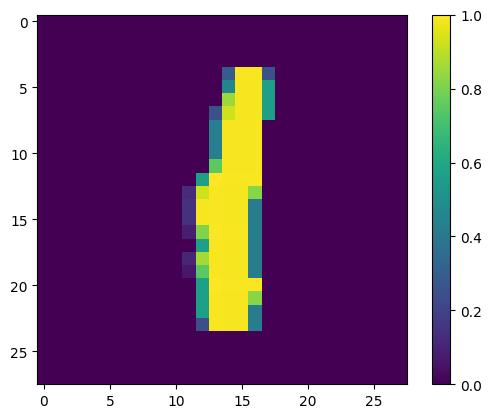

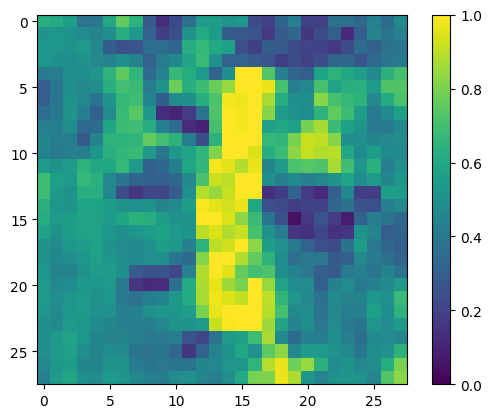

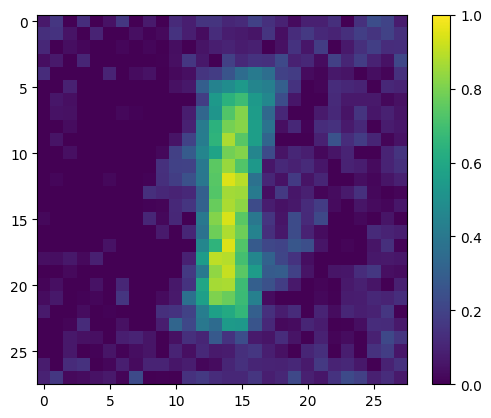

In [14]:
idx = 38
plt.figure(1)
plt.imshow(f_train_uncorrupted[0][idx, :, :, 0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

idx = 38
plt.figure(1)
plt.imshow(f_train[0][idx, :, :, 0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

plt.figure(2)
plt.imshow(post_samples_train[idx, :, :, 0], vmin=0, vmax=1)
plt.colorbar()

In [10]:
# Compute metrics on posterior samples from the training set
target = b_train[0].reshape(-1, features)
dataset_size = target.shape[0]
mnist_amp = config_base_mnist.get_config().mnist_amp

rng, _ = jax.random.split(rng)
post_samples_train = denoised_grass_dataset(state, target, rng, batch_size=batch_size)
post_samples_train = post_samples_train.reshape(dataset_size, image_shape[0], image_shape[1], image_shape[2])
jnp.save('cvae_train_posterior_samples_grass.npy', jnp.array(post_samples_train))

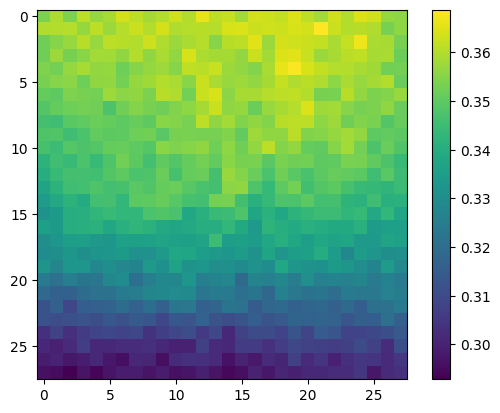

In [12]:
plt.imshow(post_samples_train[100, :, :, 0])
plt.colorbar()

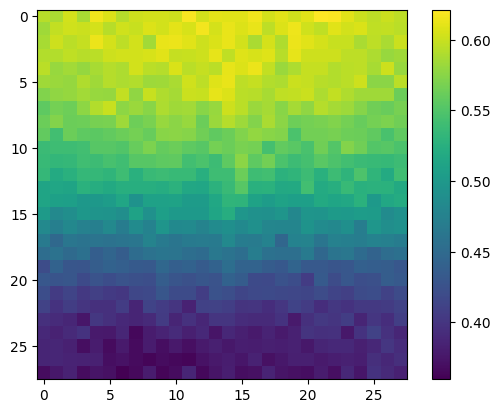

In [15]:
plt.imshow(post_samples_train[6000, :, :, 0])
plt.colorbar()

In [11]:
# Compute metrics on posterior samples from the training set
target = b_train[0].reshape(-1, features)
dataset_size = target.shape[0]
mnist_amp = config_base_mnist.get_config().mnist_amp


n_draws = 1
fcd = []
inception_score = []
pqm = []

post_samples_train_draws = []

for _n in range(n_draws):
    rng, _ = jax.random.split(rng)
    post_samples_train = denoised_grass_dataset(state, target, rng, batch_size=batch_size)
    post_samples_train = post_samples_train.reshape(dataset_size, image_shape[0], image_shape[1], image_shape[2])
    post_samples_train = post_samples_train / mnist_amp
    post_samples_train_draws.append(post_samples_train)

    inception_score.append(metrics.inception_score_mnist(classifier_model, classifier_params, post_samples_train))
    fcd.append(metrics.fcd_mnist(classifier_model, classifier_params, f_train_uncorrupted[0], post_samples_train))
    pqm.append(metrics.pq_mass_vals(f_train_uncorrupted[0], post_samples_train, 
                                    batch_size=batch_size, num_refs=num_refs))
    

    print(f'Posterior Samples:  "Inception" Score = {inception_score[-1]:.4f}, FCD = {fcd[-1]:.4f}, PQM = {pqm[-1]:.3f}')

print(f'\n "Inception" Score: {np.array(inception_score).mean():.4f} \pm {np.array(inception_score).std():.4f}')
print(f'\n FCD: {np.array(fcd).mean():.4f} \pm {np.array(fcd).std():.4f}')
print(f'\n PQM: {np.array(pqm).mean():.4f} \pm {np.array(pqm).std():.4f}')

#jnp.save('/mnt/home/aakhmetzhanova/ceph/galaxy-diffusion/corrupted-mnist/posterior_samples/cvae_train_posterior_samples.npy', jnp.array(post_samples_train_draws))

  0%|          | 0/54 [00:00<?, ?it/s]
KeyboardInterrupt



## On the validation set

In [17]:
# Compute metrics on posterior samples from the validation set.
target = f_val[0].reshape(-1, features)
dataset_size = target.shape[0]
mnist_amp = config_base_mnist.get_config().mnist_amp

n_draws = 5
fcd = []
inception_score = []
pqm = []

post_samples_val_draws = []
for _n in range(n_draws):
    rng, _ = jax.random.split(rng)
    post_samples_val = denoised_dataset(state, target, rng, batch_size=batch_size)
    post_samples_val = post_samples_val.reshape(dataset_size, image_shape[0], image_shape[1], image_shape[2])
    post_samples_val = post_samples_val / mnist_amp

    post_samples_val_draws.append(post_samples_val)

    inception_score.append(metrics.inception_score_mnist(classifier_model, classifier_params, post_samples_val))
    fcd.append(metrics.fcd_mnist(classifier_model, classifier_params, f_val_uncorrupted[0], post_samples_val))
    pqm.append(metrics.pq_mass_vals(f_val_uncorrupted[0], post_samples_val, 
                                    batch_size=batch_size, num_refs=num_refs))

    

    print(f'Posterior Samples:  "Inception" Score = {inception_score[-1]:.4f}, FCD = {fcd[-1]:.4f}, PQM = {pqm[-1]:.3f}')

print(f'\n "Inception" Score: {np.array(inception_score).mean():.4f} \pm {np.array(inception_score).std():.4f}')
print(f'\n FCD: {np.array(fcd).mean():.4f} \pm {np.array(fcd).std():.4f}')
print(f'\n PQM: {np.array(pqm).mean():.4f} \pm {np.array(pqm).std():.4f}')

jnp.save('/mnt/home/aakhmetzhanova/ceph/galaxy-diffusion/corrupted-mnist/posterior_samples/cvae_val_posterior_samples.npy', 
         jnp.array(post_samples_val_draws))

100%|██████████| 3/3 [00:00<00:00, 86.24it/s]


Posterior Samples:  "Inception" Score = 2.5591, FCD = 64.8729, PQM = 340.207


100%|██████████| 3/3 [00:00<00:00, 86.23it/s]


Posterior Samples:  "Inception" Score = 2.3468, FCD = 57.0866, PQM = 342.567


100%|██████████| 3/3 [00:00<00:00, 86.05it/s]


Posterior Samples:  "Inception" Score = 2.3984, FCD = 61.1676, PQM = 349.625


100%|██████████| 3/3 [00:00<00:00, 86.32it/s]


Posterior Samples:  "Inception" Score = 2.4229, FCD = 61.8045, PQM = 336.941


100%|██████████| 3/3 [00:00<00:00, 85.82it/s]

Posterior Samples:  "Inception" Score = 2.3445, FCD = 65.8002, PQM = 352.410

 "Inception" Score: 2.4144 \pm 0.0784

 FCD: 62.1464 \pm 3.0809

 PQM: 344.3500 \pm 5.7972


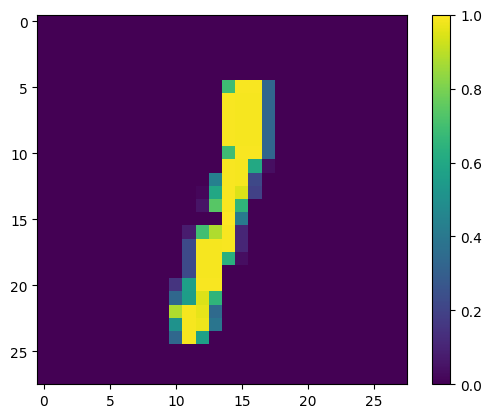

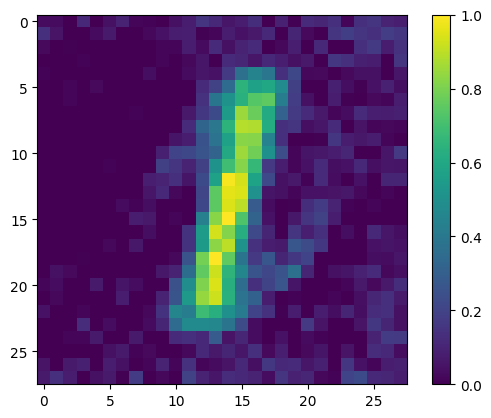

In [18]:
idx = 34
plt.figure(1)
plt.imshow(f_val_uncorrupted[0][idx, :, :, 0], vmin=0, vmax=1)
plt.colorbar()


plt.figure(2)
plt.imshow(post_samples_val[idx, :, :, 0], vmin=0, vmax=1)
plt.colorbar()

## On prior samples

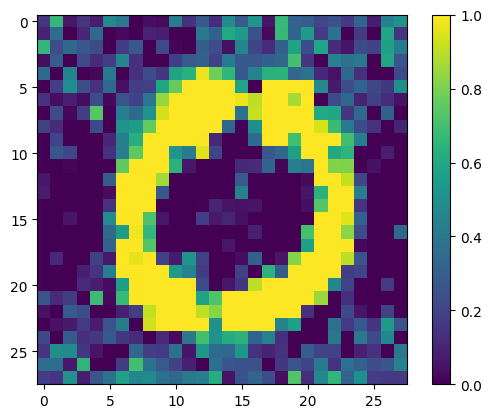

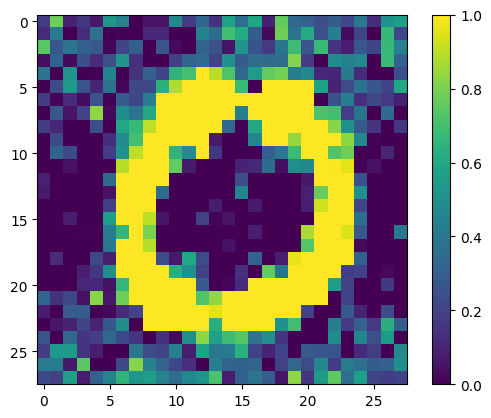

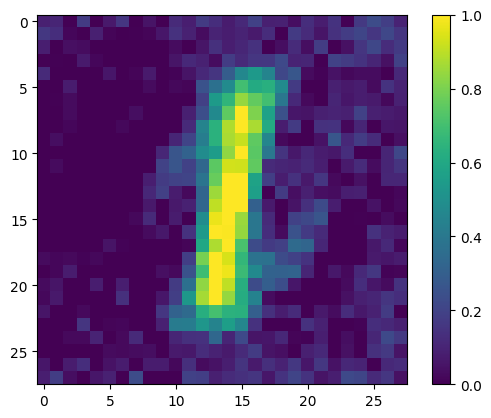

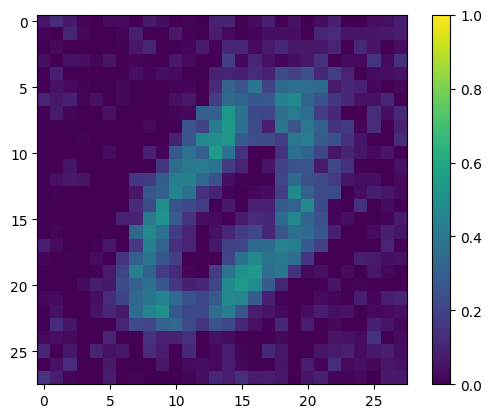

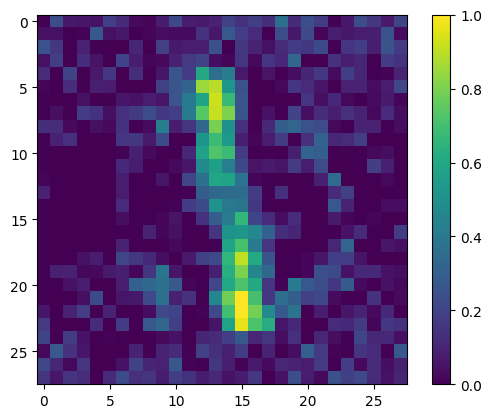

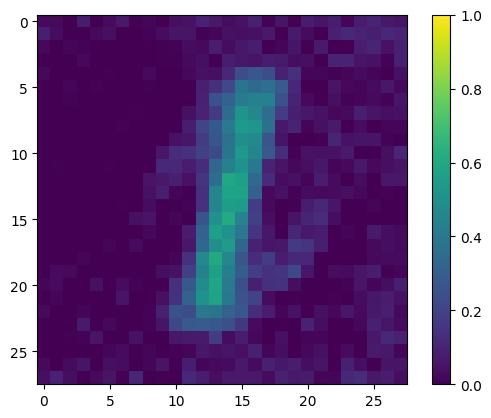

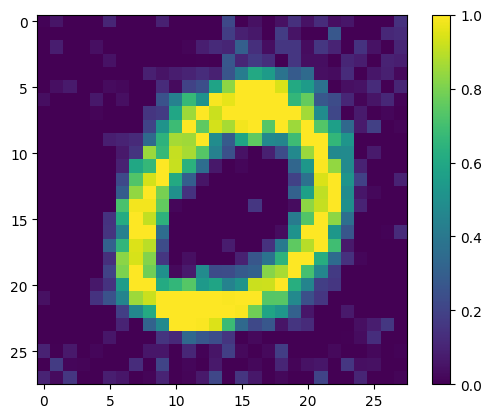

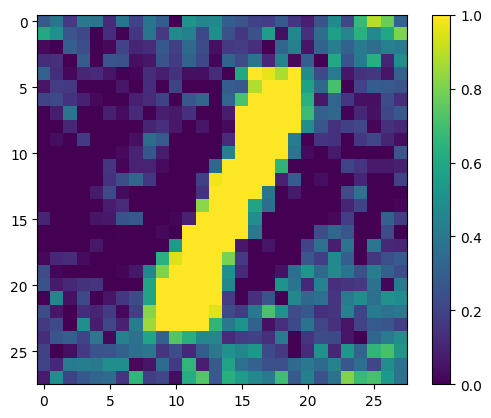

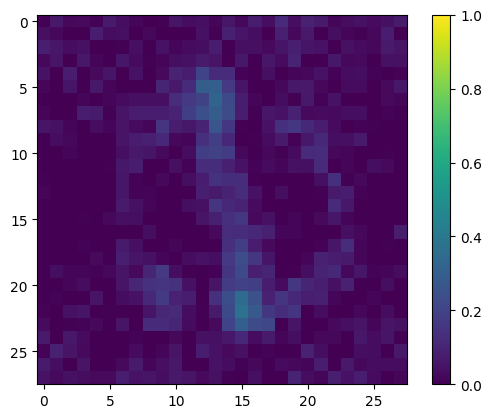

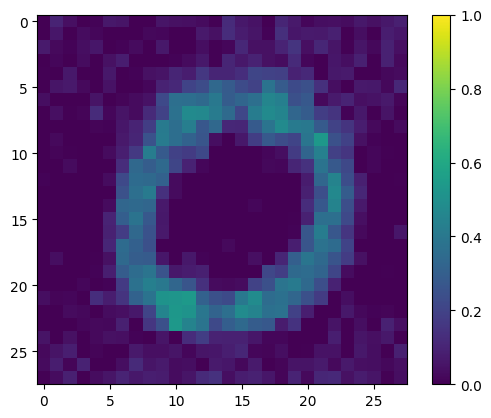

In [19]:
# Sample from the multivariate normal distribution of the latent space (assuming s ~ N(0, Id))
rng, _ = jax.random.split(rng)
sample_shape = (10_000,)
s_prior_samples = jax.random.multivariate_normal(rng, jnp.zeros(latent_features), jnp.eye(latent_features), shape=sample_shape)

mnist_amp = 0.5
rng, _ = jax.random.split(rng)
prior_samples = state.apply_fn({'params': params_cVAE}, #{'params': state.params}, 
                               s_prior_samples, jnp.zeros_like(s_prior_samples), method='decode_latent_samples')
prior_samples = prior_samples / mnist_amp

for i in range(105, 115):
    plt.figure(i)
    plt.imshow(prior_samples[i].reshape(28, 28), vmin=0, vmax=1)
    plt.colorbar()
    plt.show()

In [21]:
# Compute metrics on posterior samples from the validation set.
num_samples  = len(f_val[0])
sample_shape = (num_samples,)

n_draws = 5
fcd = []
inception_score = []
pqm = []

prior_samples_draws = []
for _n in range(n_draws):
    rng, _ = jax.random.split(rng)
    s_prior_samples = jax.random.multivariate_normal(rng, jnp.zeros(latent_features), jnp.eye(latent_features), shape=sample_shape)

    rng, _ = jax.random.split(rng)
    prior_samples = state.apply_fn({'params': params_cVAE},
                                   s_prior_samples, jnp.zeros_like(s_prior_samples), method='decode_latent_samples')
    prior_samples = prior_samples.reshape(num_samples, image_shape[0], image_shape[1], image_shape[2])
    prior_samples = prior_samples / mnist_amp

    prior_samples_draws.append(prior_samples)
    
    inception_score.append(metrics.inception_score_mnist(classifier_model, classifier_params, prior_samples))
    fcd.append(metrics.fcd_mnist(classifier_model, classifier_params, f_train_uncorrupted[0], prior_samples))
    pqm.append(metrics.pq_mass_vals(f_train_uncorrupted[0][:num_samples], prior_samples, 
                                    batch_size=batch_size, num_refs=num_refs))
    

    print(f'Posterior Samples:  "Inception" Score = {inception_score[-1]:.4f}, FCD = {fcd[-1]:.4f}, PQM = {pqm[-1]:.3f}')

print(f'\n "Inception" Score: {np.array(inception_score).mean():.4f} \pm {np.array(inception_score).std():.4f}')
print(f'\n FCD: {np.array(fcd).mean():.4f} \pm {np.array(fcd).std():.4f}')
print(f'\n PQM: {np.array(pqm).mean():.4f} \pm {np.array(pqm).std():.4f}')

jnp.save('/mnt/home/aakhmetzhanova/ceph/galaxy-diffusion/corrupted-mnist/posterior_samples/cvae_val_prior_samples.npy', 
         jnp.array(prior_samples_draws))


100%|██████████| 3/3 [00:00<00:00, 80.14it/s]

100%|██████████| 3/3 [00:00<00:00, 85.49it/s]

100%|██████████| 3/3 [00:00<00:00, 88.58it/s]


Posterior Samples:  "Inception" Score = 2.7874, FCD = 67.7680, PQM = 343.526



100%|██████████| 3/3 [00:00<00:00, 78.87it/s]

100%|██████████| 3/3 [00:00<00:00, 83.69it/s]

100%|██████████| 3/3 [00:00<00:00, 84.69it/s]


Posterior Samples:  "Inception" Score = 2.8140, FCD = 85.3399, PQM = 348.484



100%|██████████| 3/3 [00:00<00:00, 80.48it/s]

100%|██████████| 3/3 [00:00<00:00, 83.84it/s]

100%|██████████| 3/3 [00:00<00:00, 84.05it/s]


Posterior Samples:  "Inception" Score = 2.7828, FCD = 96.4049, PQM = 341.929



100%|██████████| 3/3 [00:00<00:00, 80.31it/s]

100%|██████████| 3/3 [00:00<00:00, 84.82it/s]

100%|██████████| 3/3 [00:00<00:00, 85.94it/s]


Posterior Samples:  "Inception" Score = 2.8199, FCD = 72.7712, PQM = 340.477



100%|██████████| 3/3 [00:00<00:00, 80.30it/s]

100%|██████████| 3/3 [00:00<00:00, 84.63it/s]

100%|██████████| 3/3 [00:00<00:00, 85.14it/s]

Posterior Samples:  "Inception" Score = 2.8257, FCD = 97.4105, PQM = 350.710

 "Inception" Score: 2.8060 \pm 0.0175

 FCD: 83.9389 \pm 12.0421

 PQM: 345.0251 \pm 3.9191
